## Face Recognition Using CNN

### Creating Dataset

In [36]:
import cv2
import matplotlib.pyplot as plt

In [20]:
def generate_dataset():
    face_classifier = cv2.CascadeClassifier(
        "haarcascade_frontalface_default.xml")

    def face_cropped(img):
        gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        faces = face_classifier.detectMultiScale(gray, 1.3, 5)

        if faces == ():
            return None
        for (x, y, w, h) in faces:
            cropped_face = img[y:y+h, x:x+w]
        return cropped_face

    cap = cv2.VideoCapture(0)
    id = 1
    img_id = 0

    while True:
        ret, frame = cap.read()
        if face_cropped(frame) is not None:
            img_id += 1
            face = cv2.resize(face_cropped(frame), (200, 200))
            face = cv2.cvtColor(face, cv2.COLOR_BGR2GRAY)
            file_name_path = "data/"+"Virat."+str(img_id)+".jpg"
            #file_name_path = "Images for visualization/"+str(img_id)+'.jpg'
            cv2.imwrite(file_name_path, face)
            cv2.putText(face, str(img_id), (50, 50),
                        cv2.FONT_HERSHEY_COMPLEX, 1, (0, 255, 0), 2)

            cv2.imshow("Cropped_Face", face)
            if cv2.waitKey(1) == 13 or int(img_id) == 1000:
                break

    cap.release()
    cv2.destroyAllWindows()
    print("Collecting samples is completed !!!")


### Create Label

In [31]:
import numpy as np

In [24]:
def my_label(image_name):
    name = image_name.split('.')[-3] 
    if name=="Emma":
        return np.array([1,0,0])
    elif name=="Virat":
        return np.array([0,1,0])
    elif name=="Rohit":
        return np.array([0,0,1])

### Create Data 

In [32]:
import os
from random import shuffle
from tqdm import tqdm

In [25]:
def my_data():
    data = []
    for img in tqdm(os.listdir("data")):
        path=os.path.join("data",img)
        img_data = cv2.imread(path, cv2.IMREAD_GRAYSCALE)
        img_data = cv2.resize(img_data, (50,50))
        data.append([np.array(img_data), my_label(img)])
    shuffle(data)  
    return data

In [26]:
data = my_data()

100%|████████████████████████████████████████████████████████████████████████████| 3000/3000 [00:01<00:00, 2408.00it/s]


In [27]:
train = data[:2400]  
test = data[2400:]
X_train = np.array([i[0] for i in train]).reshape(-1,50,50,1)
print(X_train.shape)
y_train = [i[1] for i in train]
X_test = np.array([i[0] for i in test]).reshape(-1,50,50,1)
print(X_test.shape)
y_test = [i[1] for i in test]

(2400, 50, 50, 1)
(600, 50, 50, 1)


### Creating the Model

In [34]:
import tensorflow as tf
from tensorflow.python.framework import ops
import tflearn
from tflearn.layers.conv import conv_2d, max_pool_2d
from tflearn.layers.core import input_data, dropout, fully_connected
from tflearn.layers.estimator import regression

In [35]:
ops.reset_default_graph()
convnet = input_data(shape=[50,50,1])
convnet = conv_2d(convnet, 32, 5, activation='relu')
convnet = max_pool_2d(convnet, 5)
convnet = conv_2d(convnet, 64, 5, activation='relu')
convnet = max_pool_2d(convnet, 5)
convnet = conv_2d(convnet, 128, 5, activation='relu')
convnet = max_pool_2d(convnet, 5)
convnet = conv_2d(convnet, 64, 5, activation='relu')
convnet = max_pool_2d(convnet, 5)
convnet = conv_2d(convnet, 32, 5, activation='relu')
convnet = max_pool_2d(convnet, 5)

convnet = fully_connected(convnet, 1024, activation='relu')
convnet = dropout(convnet, 0.8)
convnet = fully_connected(convnet, 3, activation='softmax')
convnet = regression(convnet, optimizer='adam', learning_rate = 0.001, loss='categorical_crossentropy')
model = tflearn.DNN(convnet, tensorboard_verbose=1)
model.fit(X_train, y_train, n_epoch=12, validation_set=(X_test, y_test), show_metric = True, run_id="FRS" )

Training Step: 455  | total loss: 0.16484 | time: 5.150s
| Adam | epoch: 012 | loss: 0.16484 - acc: 0.9922 -- iter: 2368/2400
Training Step: 456  | total loss: 0.14841 | time: 6.291s
| Adam | epoch: 012 | loss: 0.14841 - acc: 0.9930 | val_loss: 0.00284 - val_acc: 0.9983 -- iter: 2400/2400
--


### Data Visualization and Prediction

In [29]:
def data_for_visualization():
    Vdata = []
    for img in tqdm(os.listdir("Images for visualization")):
        path = os.path.join("Images for visualization", img)
        img_num = img.split('.')[0] 
        img_data = cv2.imread(path, cv2.IMREAD_GRAYSCALE)
        img_data = cv2.resize(img_data, (50,50))
        Vdata.append([np.array(img_data), img_num])
    shuffle(Vdata)
    return Vdata 
Vdata = data_for_visualization()

100%|█████████████████████████████████████████████████████████████████████████████████| 60/60 [00:00<00:00, 239.79it/s]


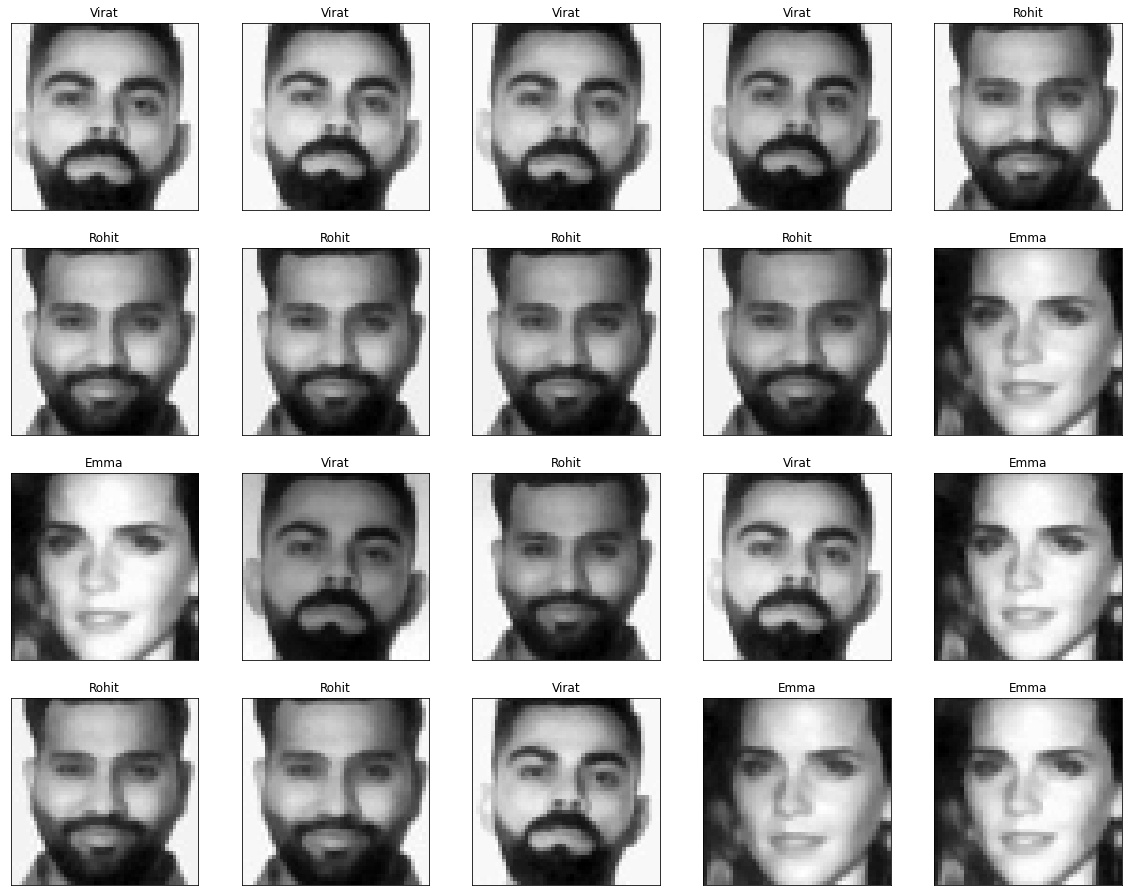

In [30]:
fig = plt.figure(figsize=(20,20))
for num, data in enumerate(Vdata[:20]):
    img_data = data[0]
    y = fig.add_subplot(5,5, num+1)
    image = img_data
    data = img_data.reshape(50,50,1)
    model_out = model.predict([data])[0]
    
    if np.argmax(model_out) == 0:
        my_label = 'Emma'
    elif np.argmax(model_out) == 1:
        my_label = 'Virat'
    else:
        my_label = 'Rohit'
        
    y.imshow(image, cmap='gray')
    plt.title(my_label)
    
    y.axes.get_xaxis().set_visible(False)
    y.axes.get_yaxis().set_visible(False)
plt.show()